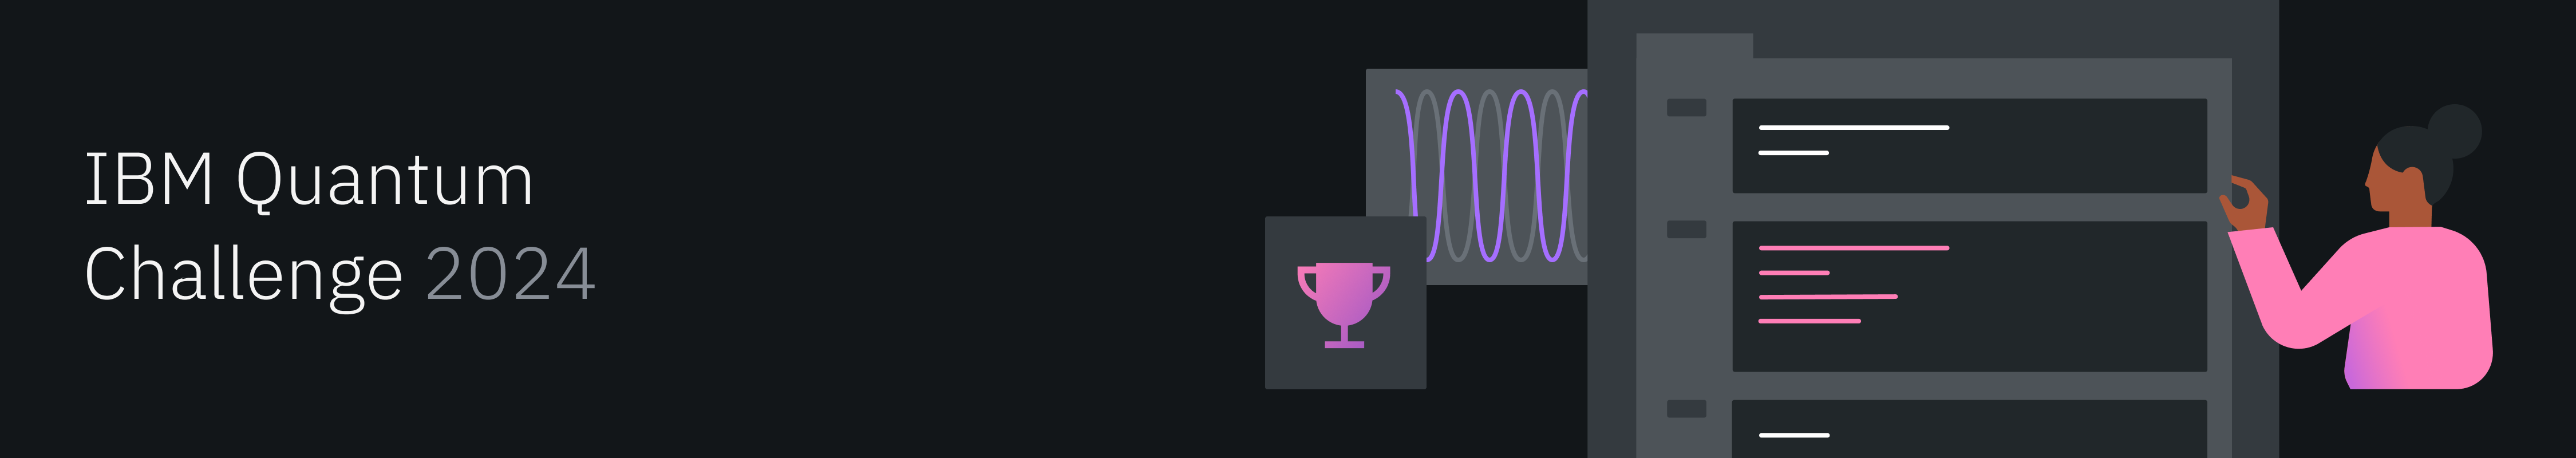

# Lab 3: What's Next - Sneak Preview of Qiskit Serverless

# Table of Contents

* [Part 1: Creating and deplyoing programs on Qiskit Serverless](#Exploring-Qiskit-Serverless:-Running-workloads-remotely-using-Qiskit-Serverless)
    * [Exercise 1](#exercise1)
* [Part 2: Deploying parallel workflows on Qiskit Serverless](#Part-2:-Running-Distributed-workflows---Parallel-Transpilation-with-Qiskit-Serverless)
    * [Exercise 2](#exercise2)

# Imports

In [ ]:
### Install Qiskit and relevant packages, if needed
### IMPORTANT: Make sure you are on 3.10 > python < 3.12
%pip install qiskit[visualization]==1.0.2
%pip install qiskit-ibm-runtime
%pip install qiskit-aer
%pip install graphviz
%pip install qiskit-serverless -U
%pip install qiskit-transpiler-service -U
%pip install git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git -U

In [55]:
### Save API Token, if needed

%set_env QXToken=TOKEN

# Make sure there is no space between the equal sign
# and the beginning of your token

env: QXToken=TOKEN


In [2]:
# qc-grader should be 0.18.12 (or higher)
import qc_grader

qc_grader.__version__

'0.18.13'

Now, let's run our imports and setup the grader

In [3]:
# Import all in one cell

import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import warnings

from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Options
from qiskit_serverless import QiskitFunction, save_result, get_arguments, save_result, distribute_task, distribute_qiskit_function, IBMServerlessClient, QiskitFunction
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_transpiler_service.transpiler_service import TranspilerService
from qiskit_aer import AerSimulator

In [4]:
# Import for grader
from qc_grader.challenges.iqc_2024 import grade_lab3_qs_ex1, grade_lab3_qs_ex2

# Introduction

Welcome to Lab 3! Today, we are thrilled to give you an exclusive sneak peek into some of the exciting new features that are being developed for the Qiskit stack. This educational challenge is split into separate notebooks, each showcasing a unique and groundbreaking innovation and invites you to explore and test these new features. Dive in to explore tools like the Circuit Knitting Toolbox to simplify complex quantum circuits, experience the workflow to setup seamless integration of quantum and classical computing with Qiskit Serverless and have a chance to leverage AI-Powered tools like the Qiskit Code Assistant for code generation and circuit optimization with AI-Powered Transpiler Passes. Dive in and discover how these innovations are set to revolutionize quantum development!

<div class="alert alert-block alert-danger">

Please note, **these features are in beta and release preview**, so you most likely may encounter some bugs. Have fun experimenting and pushing the boundaries of quantum development!

</div>

# Exploring Qiskit Serverless: Running workloads remotely using Qiskit Serverless

Welcome to this exercise, where we will revisit a previous exercise from Lab 1 and deploy the Variational Quantum Eigensolver (VQE) as a `QiskitFunction` using **Qiskit Serverless**. Qiskit Serverless is a user-friendly tool that enables you to easily run complex quantum computing tasks. With this software, you can execute Qiskit programs as long running jobs and distribute them across multiple CPUs, GPUs, and QPUs. This means you can take on more complex quantum-classical programs and run them with ease. You don't have to worry about configuration or scaling up computational resources, as Qiskit Serverless takes care of everything for you. Creating utility-scale quantum applications generally requires a variety of compute resource requirements. You can use Qiskit Serverless to easily submit quantum workflows for remote, managed execution on IBM Quantum Platform. These quantum workflows can typically be implemented within a common pattern, called a Qiskit Pattern. 

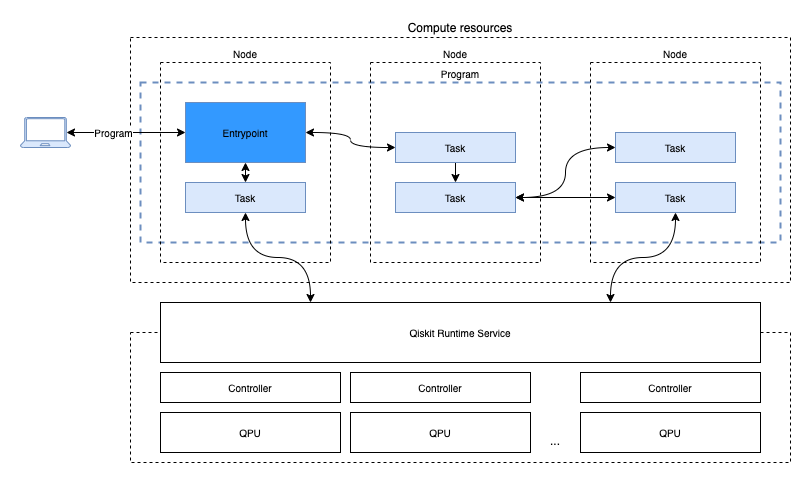

This exercise will guide you through leveraging Qiskit Serverless capabilities to execute VQE. By the end of this exercise, you will have practical experience deploying and running a quantum algorithm in a serverless environment, enhancing your understanding of quantum computing workflows. Let's get started!

<div class="alert alert-block alert-danger">

**Please note:** This notebook needs additional scripts located in the same [folder](https://github.com/qiskit-community/ibm-quantum-challenge-2024/tree/main/content/lab_3). Ensure you transfer and store these files in the same directory as the notebook in your environment. The scripts required are: `vqe.py`, `transpile_parallel.py` and `utils.py`.

</div>

## Part 1: Workflow for creating and deploying programs on a serverless environment using Qiskit Serverless

<a id="exercise1"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 1:</b> 

Fill in the code blocks as per the instructions. We will revisit the concepts learned in Lab 1 and apply them using Qiskit Serverless. Follow the steps carefully and ensure you understand each part of the process. 

</div>

This exercise will guide you through setting up, deploying, executing, and analyzing a Variational Quantum Eigensolver (VQE) algorithm using Qiskit Serverless

## Step 1: Define the problem - Revisit Lab 1 example

Let's set up the experiment using the VQE example from Lab 1. We will use the same ansatz, parameters, and Hamiltonian operator defined previously. We will be consist with lab 1 so that we can compare results effectively. Begin by reviewing the Lab 1 notebook to recall the specific details and configurations used for the VQE algorithm. Ensure you have all the necessary components ready for implementation in the current exercise.

In [5]:
# If needed setup your QiskitRuntimeService

QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="TOKEN",
    set_as_default=True,
    # Use `overwrite=True` if you're updating your token.
    overwrite=True,
)

service = QiskitRuntimeService(channel="ibm_quantum")
 
# Specify a system to use for transpilation
real_backend = service.backend("ibm_brisbane")

<a id="exercise1"></a>
<div class="alert alert-block alert-success">
    
<b> Task: </b> Fill in the problem definiton below. The problem definition is the same as what we did in [`Lab 1`](https://github.com/qiskit-community/ibm-quantum-challenge-2024/tree/main/content/lab_1). Feel free to refer back to [`Lab 1`](https://github.com/qiskit-community/ibm-quantum-challenge-2024/tree/main/content/lab_1) for a refresher.
</div>

In [6]:
# Qiskit Pattern Step 1: Map quantum circuits and operators (Define Ansatz and operators)
num_qubits = 3
rotation_blocks = ['ry', 'rz'] # Add your code here
entanglement_blocks = 'cz' # Add your code here
entanglement = 'full' # Add your code here

# Define Ansatz
ansatz = TwoLocal(num_qubits, rotation_blocks, entanglement_blocks, entanglement, reps=1, insert_barriers=True) # Add your code here

# Define parameters
num_params = ansatz.num_parameters

# Qiskit Pattern Step 2: Optimize the circuit for quantum execution
optimization_level = 2
pm = generate_preset_pass_manager(backend=real_backend, optimization_level=optimization_level)
isa_circuit = pm.run(ansatz) # Add your code here

# Define Hamiltonian for VQE
pauli_op = SparsePauliOp(['ZII', 'IZI', 'IIZ'])
hamiltonian_isa = pauli_op.apply_layout(layout=isa_circuit.layout)

## Step 2: Set Up Qiskit Serverless

Let's ensure our environment is configured for Qiskit Serverless. First, install the Qiskit Serverless package if you haven't already. Then, define your token and set up the `IBMServerlessClient` to use your IBM Quantum account. This will enable you to access the serverless capabilities. We will be using local testing mode for this exercise, so we'll set up QiskitRuntime without a service. If you wish to run on real backends, change the `USE_RUNTIME_SERVICE` flag to True. Ensure you have your IBM Quantum token handy for authentication and authorization.

In [7]:
# Setup Qiskit Serverless Client and Qiskit Runtime client
client = IBMServerlessClient("TOKEN") # Add in your IBM Quantum Token to QiskitServerless Client

# For the challenge, we will be using QiskitRuntime Local testing mode. Change to True only if you wish to use real backend.
USE_RUNTIME_SERVICE = False

if USE_RUNTIME_SERVICE:
    service = QiskitRuntimeService(
        channel='ibm_quantum', 
        verify=False
    )
else:
    service = None

## Step 3: Create and deploy `QiskitFunction` on cloud
We have already created a `vqe.py` file containing the necessary run functions. **Review this file to understand the workflow.** Next, we will define a Qiskit Function that points to this file. Fill in the necessary details in the template provided below. API Documentation reference for `QiskitFunction` can be found [here](https://qiskit.github.io/qiskit-serverless/stubs/qiskit_serverless.core.QiskitFunction.html#qiskit_serverless.core.QiskitFunction)

<a id="exercise1"></a>
<div class="alert alert-block alert-success">
    
<b> Task: </b> Complete the initialization of `QiskitFunction` template below. The file to point and use for this exercise is [`vqe.py`](./vqe/vqe.py)
</div>

<div class="alert alert-block alert-danger">

**Please note:** If you're using a cloud-hosted Jupyter environment like Colab, make sure you select the correct working directory. Change the directory by adding the relative path of the folder to the `working_dir` of the file you want to access. Ensure you have write access to the directory.

</div>

In [8]:
# Define the Qiskit Function
if USE_RUNTIME_SERVICE:
    function = QiskitFunction(title= "vqe", entrypoint="vqe.py", working_dir="./vqe")
else:
    function = QiskitFunction(title= "vqe" , entrypoint="vqe.py", working_dir="./vqe",  dependencies=["qiskit_aer"])


In [9]:
# Upload the Qiskit Function using IBMServerlessClient
client.upload(function)

'vqe'

## Step 4: Execute the VQE 
Now that we have uploaded our `QiskitFunction`, we are ready to execute the VQE algorithm using Qiskit Serverless. Follow these steps and specify the necessary variables to run the algorithm and retrieve the results:

Use method `"COBYLA"` for the optimizer arguments

<a id="exercise3"></a>
<div class="alert alert-block alert-success">
    
<b> Task: </b> Fill in the arguments dictionary to be passed on to the QiskitFunction. Fill in the `ansatz`, `operator`, `method` and `service` as per the problem formation

</div>

In [12]:
# Define input_arguments
input_arguments = {
    "ansatz": isa_circuit, # Replace with your transpiled ansatz
    "operator": hamiltonian_isa, # Replace with the hamiltonian operator
    "method": "COBYLA", # Using COBYLA method for the optimizer
    "service": service # Add your code here
}

# Qiskit Pattern Step 3: Run the payload on backend
job = client.run("vqe", arguments=input_arguments) # Pass the arguments dict here)

<a id="exercise3"></a>
<div class="alert alert-block alert-success">
    
<b> Task: </b> Ensure you have the right types are passed to the function. Run the grader to finish this exercise.

</div>

In [13]:
# Submit your answer using following code

grade_lab3_qs_ex1(function, input_arguments, job)
# Expected result type: QiskitFunction, dict, Job

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [14]:
# Return jobid
job

<Job | 528d4dfb-b74e-41a3-a84a-117325d9afc2>

<div class="alert alert-block alert-warning">

**IMPORTANT:** The challenge cluster is a shared resource, so you may experience some wait time for queues for execution. Please feel free to check out the pre-run results below or run the cells yourself to see your results.

#### Monitor Job execution status
Monitor the status of the execution and wait for it to complete. You can rerun the cell again to ping for the latest status

In [17]:
# Check job completion status
job.status()

'DONE'

In [18]:
# Monitor log
logs = job.logs()

for log in logs.splitlines():
    print(log)

Iters. done: 1 [Avg. time per iter: -]
Iters. done: 2 [Avg. time per iter: 0.04]
Iters. done: 3 [Avg. time per iter: 0.05]
Iters. done: 4 [Avg. time per iter: 0.04]
Iters. done: 5 [Avg. time per iter: 0.04]
Iters. done: 6 [Avg. time per iter: 0.04]
Iters. done: 7 [Avg. time per iter: 0.04]
Iters. done: 8 [Avg. time per iter: 0.04]
Iters. done: 9 [Avg. time per iter: 0.05]
Iters. done: 10 [Avg. time per iter: 0.05]
Iters. done: 11 [Avg. time per iter: 0.06]
Iters. done: 12 [Avg. time per iter: 0.05]
Iters. done: 13 [Avg. time per iter: 0.06]
Iters. done: 14 [Avg. time per iter: 0.06]
Iters. done: 15 [Avg. time per iter: 0.06]
Iters. done: 16 [Avg. time per iter: 0.06]
Iters. done: 17 [Avg. time per iter: 0.06]
Iters. done: 18 [Avg. time per iter: 0.08]
Iters. done: 19 [Avg. time per iter: 0.07]
Iters. done: 20 [Avg. time per iter: 0.07]
Iters. done: 21 [Avg. time per iter: 0.07]
Iters. done: 22 [Avg. time per iter: 0.07]
Iters. done: 23 [Avg. time per iter: 0.08]
Iters. done: 24 [Avg. t

#### Retrieve Results:
Once the execution is complete, retrieve and analyze the results.

In [19]:
# Return result from QiskitFunction job
job.result()

{'optimal_point': [3.0866290471205406,
  3.164283231981789,
  -0.05158710980450653,
  2.1172575497757657,
  4.871139107011885,
  5.2598774612874655,
  0.12517296771733674,
  0.08956336747263129,
  3.1703854027926908,
  5.046324058232039,
  0.9315754081510039,
  1.0212767150056392],
 'optimal_value': -2.98876953125,
 'optimizer_time': 7.277864618226886,
 'iters': 115,
 'cost_history': [-1.93896484375,
  -1.591796875,
  -2.3798828125,
  -1.8017578125,
  -2.36962890625,
  -2.34765625,
  -2.68359375,
  -2.19189453125,
  -2.02197265625,
  -2.83740234375,
  -2.84423828125,
  -2.83251953125,
  -2.82373046875,
  -2.67822265625,
  -2.84033203125,
  -2.4326171875,
  -2.7685546875,
  -2.81298828125,
  -2.48193359375,
  -2.8408203125,
  -2.82763671875,
  -2.76318359375,
  -2.83837890625,
  -2.86083984375,
  -2.8349609375,
  -2.9248046875,
  -2.92333984375,
  -2.9228515625,
  -2.93359375,
  -2.96240234375,
  -2.947265625,
  -2.97998046875,
  -2.95849609375,
  -2.97314453125,
  -2.97705078125,
  -2.

## Step 5: Analyze the Results
Retrieve and analyze the results of the VQE execution to gain insights into the performance of your quantum algorithm. Compare these results with your expectations and the outcomes from Lab 1. Evaluate the optimal energy and parameters obtained from the Qiskit Serverless execution, and see how they match up with the previous lab results.

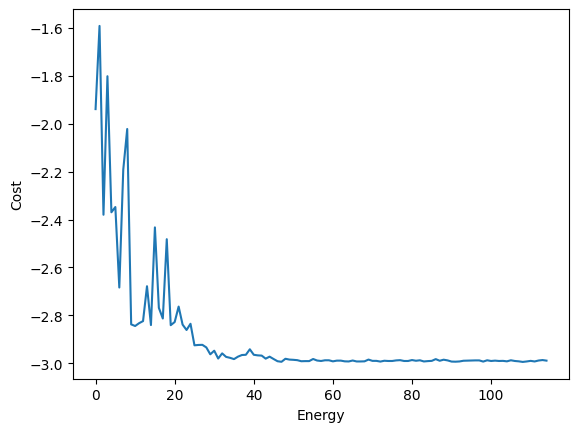

In [20]:
# Qiskit Pattern Step 4: Postprocess and analyze the Estimator V2 results
result = job.result()

fig, ax = plt.subplots()
plt.plot(range(result["iters"]), result["cost_history"])
plt.xlabel("Energy")
plt.ylabel("Cost")
plt.draw()

# Part 2: Running Distributed Workflows - Parallel Transpilation with Qiskit Serverless

Now that you have learnt how to deploy quantum algorithms on serverless, we'll now delve into how Qiskit's serverless infrastructure can supercharge your quantum workflows. For an example showcase, we will learn how to transpile quantum circuits concurrently using different configurations of the Qiskit transpiler and Qiskit transpiler service to find the optimal circuit for a given quantum backend.

#### Leveraging Qiskit Serverless for Distributed Tasks
Qiskit's serverless framework is designed to handle distributed parallel computing tasks seamlessly. With serverless computing, you don't have to worry about managing the underlying infrastructure. Resources are dynamically allocated, parallelized and scaled according to your needs, allowing you to focus on the quantum tasks at hand.


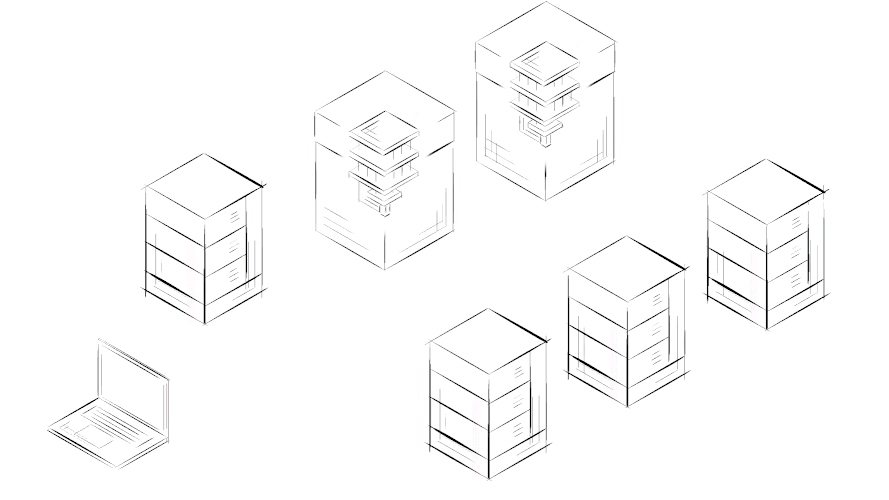

Transpilation is a critical step in preparing quantum circuits for execution on quantum hardware. It involves converting a high-level quantum circuit into a form that a quantum computer can understand and execute efficiently. As circuits grow in complexity, this process can become increasingly time-consuming. The example here showcases a workflow of parallel transpilation which distributes the task across multiple computational resources, allowing you to explore various optimization strategies simultaneously. **Lets begin!**

<a id="exercise2"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 2:</b> 

Fill in the empty code blocks as per the instructions. We will revisit the experiment from the [`Lab 3 AI Transpiler lab`](https://github.com/qiskit-community/ibm-quantum-challenge-2024/tree/main/content/lab_3) and apply a parallel transpilation workflow using Qiskit Serverless. Follow the steps carefully and ensure you understand each part of the process.

</div>


## Step 1: Setting up circuits

We begin by setting up the quantum circuits we want to optimize. These circuits will be the basis for the transpilation process. We will use a similar example from Lab 3 - AI Transpiler notebook for comparision:


In [21]:
# Setup 3 circuits with Efficient SU2
num_qubits = [41, 51, 61]
circuits = [EfficientSU2(nq, su2_gates=["rz","ry"], entanglement="circular", reps=1).decompose() for nq in num_qubits]

## Pick a backend

Our abstract circuits are going to be optimised to run on this backend

In [22]:
# Setup Qiskit Runtime Service backend

# QiskitRuntimeService.save_account(
#     channel="ibm_quantum",
#     token="YOUR_IBM_QUANTUM_TOKEN",
#     set_as_default=True,
#     # Use 'overwrite=True' if you're updating your token.
#     overwrite=True,
# )

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibm_brisbane")

## Step 2: Setup Transpiler Configurations

We define multiple transpiler configurations with different optimization levels and strategies. Each configuration represents a different way of transpiling the circuit. The configurations we are selecting are `optimization_level` values of `1`, `2`, and `3` for local Qiskit transpilation, and `optimization_level` of `3` for `Qiskit Transpiler Service` with `ai=False` and `ai=True`. Each circuit will go through all these transpilation passes, and the best result from these will be selected as the optimal circuit.

<div class="alert alert-block alert-info">

**IMPORTANT:** We will be using the Qiskit Transpiler service for this section. Please ensure you have the `qiskit-transpiler-service package` installed and your token set up to use the IBM Quantum Platform. You can find instructions on how to do this in the documentation link [here](https://docs.quantum.ibm.com/start/setup-channel#set-up-to-use-ibm-quantum-platform)

</div>

<a id="exercise1"></a>
<div class="alert alert-block alert-success">
    
<b> Task: </b> Fill in the empty code block below as per the setup configuration specified in the text above.
</div>

In [23]:
# Define Configs
optimization_levels = [1, 2, 3] # Add your code here
pass_managers = [{'pass_manager': generate_preset_pass_manager(optimization_level=level, backend=backend), 'optimization_level': level} for level in optimization_levels]

transpiler_services = [ 
        {'service': TranspilerService(backend_name="ibm_brisbane", ai=False, optimization_level=3), 'ai': False, 'optimization_level': 3},
        {'service': TranspilerService(backend_name="ibm_brisbane", ai=True, optimization_level=3), 'ai': True, 'optimization_level': 3}
    ]

configs = pass_managers + transpiler_services

## Step 3: Local Transpilation
Before distributing the tasks, let us run the transpilation locally to compare the results and establish a baseline. This step will help us ensure that our configurations are working as expected.

In [24]:
# Local transpilation setup
def transpile_parallel_local(circuit: QuantumCircuit, config):
    """Transpilation for an abstract circuit into an ISA circuit for a given config."""
    transpiled_circuit = config.run(circuit)
    return transpiled_circuit

<div class="alert alert-block alert-warning">

**IMPORTANT:** Please note, this step may take a few minutes to run locally.

In [25]:
# Run local transpilation
warnings.filterwarnings("ignore")

start = timer()

# Run transpilations locally for baseline
results = []
for circuit in circuits:
    for config in configs:
        if 'pass_manager' in config:
            results.append(transpile_parallel_local(circuit, config['pass_manager']))
        else:
            results.append(transpile_parallel_local(circuit, config['service']))
            
end = timer()

# Record local execution time
execution_time_local = end - start
print("Execution time locally: ", execution_time_local)

INFO:qiskit_transpiler_service.transpiler_service:Requesting transpile to the service
INFO:qiskit_transpiler_service.transpiler_service:Qiskit transpiler service returned a result
INFO:qiskit_transpiler_service.transpiler_service:Requesting transpile to the service
INFO:qiskit_transpiler_service.transpiler_service:Qiskit transpiler service returned a result
INFO:qiskit_transpiler_service.transpiler_service:Requesting transpile to the service
INFO:qiskit_transpiler_service.transpiler_service:Qiskit transpiler service returned a result
INFO:qiskit_transpiler_service.transpiler_service:Requesting transpile to the service
INFO:qiskit_transpiler_service.transpiler_service:Qiskit transpiler service returned a result
INFO:qiskit_transpiler_service.transpiler_service:Requesting transpile to the service
INFO:qiskit_transpiler_service.transpiler_service:Qiskit transpiler service returned a result
INFO:qiskit_transpiler_service.transpiler_service:Requesting transpile to the service
INFO:qiskit_tr

Execution time locally:  449.82054247299993


## Step 4: Setting up Qiskit Serverless Client
We will now use Qiskit Serverless module's capabilities to distribute these transpilation tasks across multiple computational nodes. From here, we will start setting up Qiskit Serverless to run and deploy distributed tasks.

First, we'll authenticate with Qiskit Serverless service on IBM Quantum Platform. This uses your default IBM Quantum Platform API Token

In [26]:
# Authenticate to the remote cluster and submit the pattern for remote execution if not done in previous exercise
serverless = IBMServerlessClient("TOKEN")

## Step 5: Create and deploy `QiskitFunction` on cloud
We have already created a `transpile_parallel.py` file containing the necessary run functions. **Review this file to understand the workflow.** Next, we will define a Qiskit Function that points to this file. Fill in the necessary details in the template provided below. API Documentation reference for `QiskitFunction` can be found [here](https://qiskit.github.io/qiskit-serverless/stubs/qiskit_serverless.core.QiskitFunction.html#qiskit_serverless.core.QiskitFunction)

```python
# transpile_parallel.py

# Define Distributed task function and decorate it
@distribute_task(target={"cpu": 2})
def transpile_parallel(circuit: QuantumCircuit, config):
    """Distributed transpilation for an abstract circuit into an ISA circuit for a given backend."""
    transpiled_circuit = config.run(circuit)
    return transpiled_circuit


# Get program arguments
arguments = get_arguments()
circuits = arguments.get("circuits")
backend_name = arguments.get("backend_name")

# run distributed tasks as async function
# we get task references as a return type
sample_task_references = []
for circuit in circuits:
    sample_task_references.append([transpile_parallel(circuit, config) for config in configs])

# now we need to collect results from task references
results = get([task for subtasks in sample_task_references for task in subtasks])

save_result({
    "transpiled_circuits": results
})
```

<a id="exercise1"></a>
<div class="alert alert-block alert-success">
    
<b> Task: </b> Complete the empty code sections in the file [`transpile_parallel.py`](./transpile_parallel/transpile_parallel.py). Review the file to understand the workflow and verify that it is runnable.
</div>

**Let's delve deeper into the new concepts introduced in this pattern:** The [`distribute_task`](https://qiskit.github.io/qiskit-serverless/stubs/qiskit_serverless.core.distribute_task.html#qiskit_serverless.core.distribute_task) decorator transforms a function into a distributed task, allowing it to run on separate compute resources asynchronously and in parallel with the main context.

When a function decorated with `distribute_task` is called, it returns a reference to the function execution instead of the actual result. To retrieve the result, you need to call the `get` function on this reference. The `get` function waits for the task to complete and then returns the function's result.

In the pattern above, we've applied the `distribute_task` decorator to the `transpile_parallel` function. This function accepts a QuantumCircuit and a transpiler config as inputs, and it returns the circuit transpiled according to the provided configuration. Once we have the results, we can save them using the `save_result` function.

Essentially, this pattern reads the circuits from the pattern arguments, executes the `transpile_parallel` function on each circuit and config in parallel, collects the results from the function executions, and saves the results. You can read more on the whole workflow in the tutorial [here](https://qiskit.github.io/qiskit-serverless/getting_started/basic/04_distributed_workloads.html)

<a id="exercise1"></a>
<div class="alert alert-block alert-success">
    
<b> Task: </b> Complete the initialization of `QiskitFunction` template below. The file to point and use for this exercise is `transpile_parallel.py`
</div>

In [27]:
transpile_parallel_function = QiskitFunction(
    title="transpile_parallel",
    entrypoint="transpile_parallel.py",
    working_dir="./transpile_parallel",
    dependencies=["qiskit-transpiler-service"]
)

In [28]:
serverless.upload(transpile_parallel_function)

'transpile_parallel'

## Step 4: Execute the function on a serverless environment
Now that we have uploaded our `QiskitFunction`,  we will run our transpilation tasks in a serverless environment and leverage Qiskit's serverless capabilities to distribute and execute these tasks efficiently. We can additionally also retrieve any function that we have previously uploaded. We can do so below:

In [29]:
# Get list of functions
serverless.list()

[QiskitFunction(vqe), QiskitFunction(transpile_parallel)]

<a id="exercise1"></a>
<div class="alert alert-block alert-success">
    
<b> Task: </b> Complete the workflow below. Use the [`get`](https://qiskit.github.io/qiskit-serverless/stubs/qiskit_serverless.core.IBMServerlessClient.html#qiskit_serverless.core.IBMServerlessClient) function to fetch a specific function. Finally, execute your job by running your serverless function. Ensure you are passing the necessary arguments for the function by analyzing the file `transpile_parallel.py`
</div>

In [33]:
# Fetch the specific function titled "transpile_parallel"
transpile_parallel_serverless = serverless.get('transpile_parallel') # Add your code here

In [34]:
# Run the "transpile_parallel" function in the serverless environment
job = transpile_parallel_serverless.run(
    circuits= circuits, # Add your code here,
    backend_name= 'ibm_brisbane' # Add your code here
                                       )

<a id="exercise3"></a>
<div class="alert alert-block alert-success">
    
<b> Task: </b> Ensure you have the right types are passed to the function. Run the grader to finish this exercise.

</div>

In [35]:
# Submit your answer using following code

grade_lab3_qs_ex2(optimization_levels, transpiler_services, transpile_parallel_function, transpile_parallel_serverless, job)
# Expected result type: list, list, QiskitFunction, QiskitFunction, Job

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


#### Monitor Job execution status
Monitor the status of the execution and wait for it to complete. You can rerun the cells below again to ping for the latest status

<div class="alert alert-block alert-warning">

**IMPORTANT:** The challenge cluster is a shared resource, so you may experience some wait time for queues for execution. Please feel free to check out the prerun results below or run the cells yourself to see your results.

In [49]:
job.status()

'DONE'

In [50]:
logs = job.logs()

for log in logs.splitlines():
    print(log)

Starting timer
2024-06-14 00:26:39,884	INFO worker.py:1405 -- Using address 172.17.39.85:6379 set in the environment variable RAY_ADDRESS
2024-06-14 00:26:39,884	INFO worker.py:1540 -- Connecting to existing Ray cluster at address: 172.17.39.85:6379...
2024-06-14 00:26:39,899	INFO worker.py:1715 -- Connected to Ray cluster. View the dashboard at 172.17.39.85:8265 
(transpile_parallel pid=272, ip=172.17.21.56) INFO:qiskit_transpiler_service.transpiler_service:Requesting transpile to the service
(transpile_parallel pid=271, ip=172.17.21.56) INFO:qiskit_transpiler_service.transpiler_service:Qiskit transpiler service returned a result
(transpile_parallel pid=966) INFO:qiskit_transpiler_service.transpiler_service:Requesting transpile to the service [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(transpile_parallel pi

#### Retrieve Results:
Once the execution is complete, retrieve and analyze the results.

In [51]:
result = job.result()
result_transpiled = result["transpiled_circuits"]

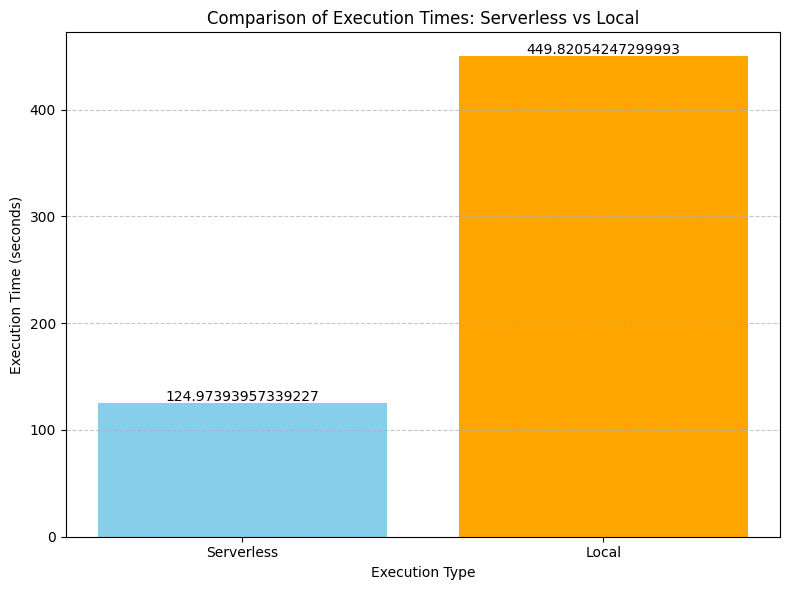

In [52]:
# Compare execution times:
execution_time_serverless = result["execution_time"]

from utils import plot_execution_times
plot_execution_times(execution_time_serverless, execution_time_local)

## Step 5: Collect and Compare Results
Once the transpilation tasks are complete, gather the results and compare the transpiled circuits. Here, we evaluate based on the shortest depth of the transpiled circuit result to determine the best-performing circuit.



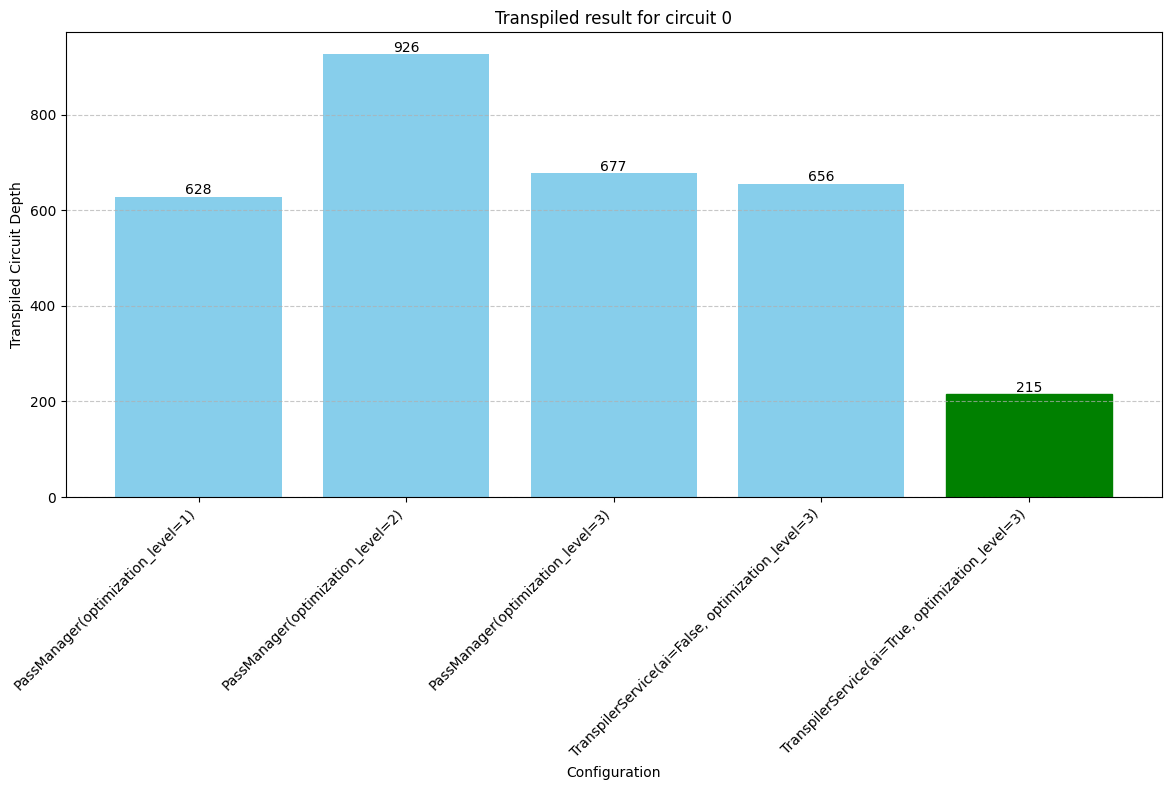

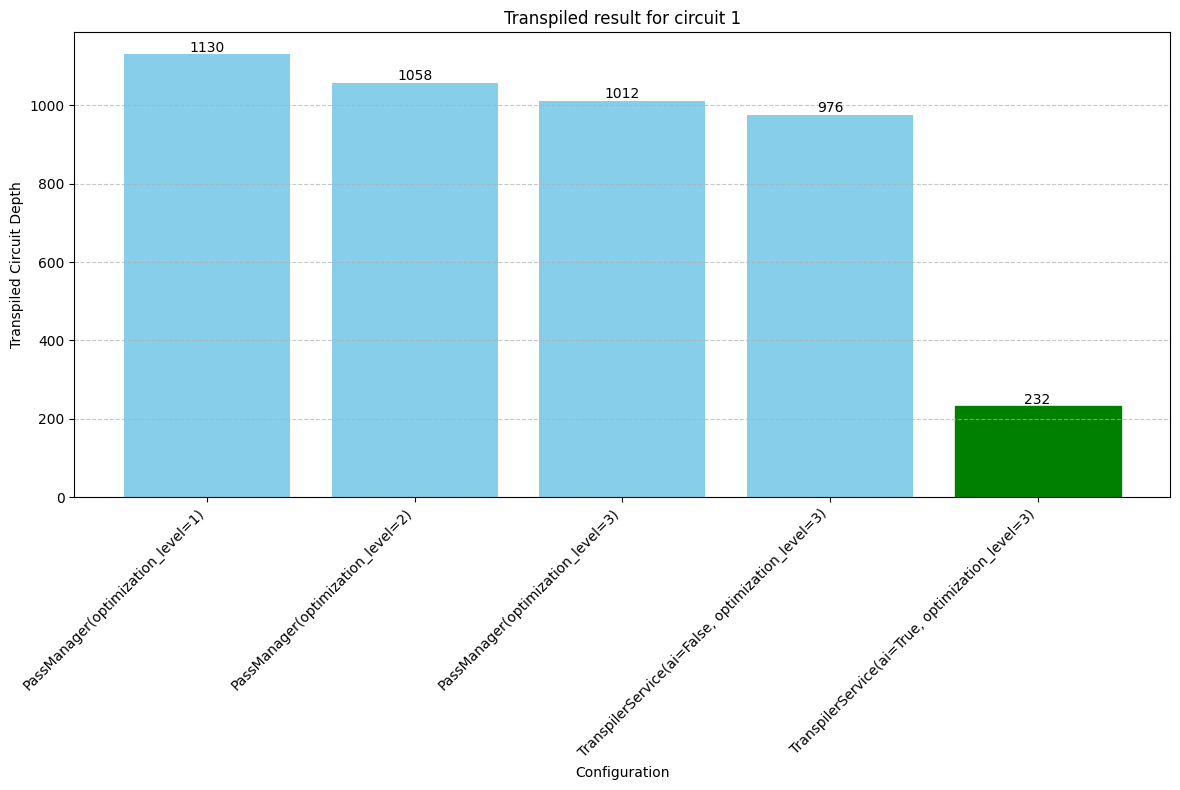

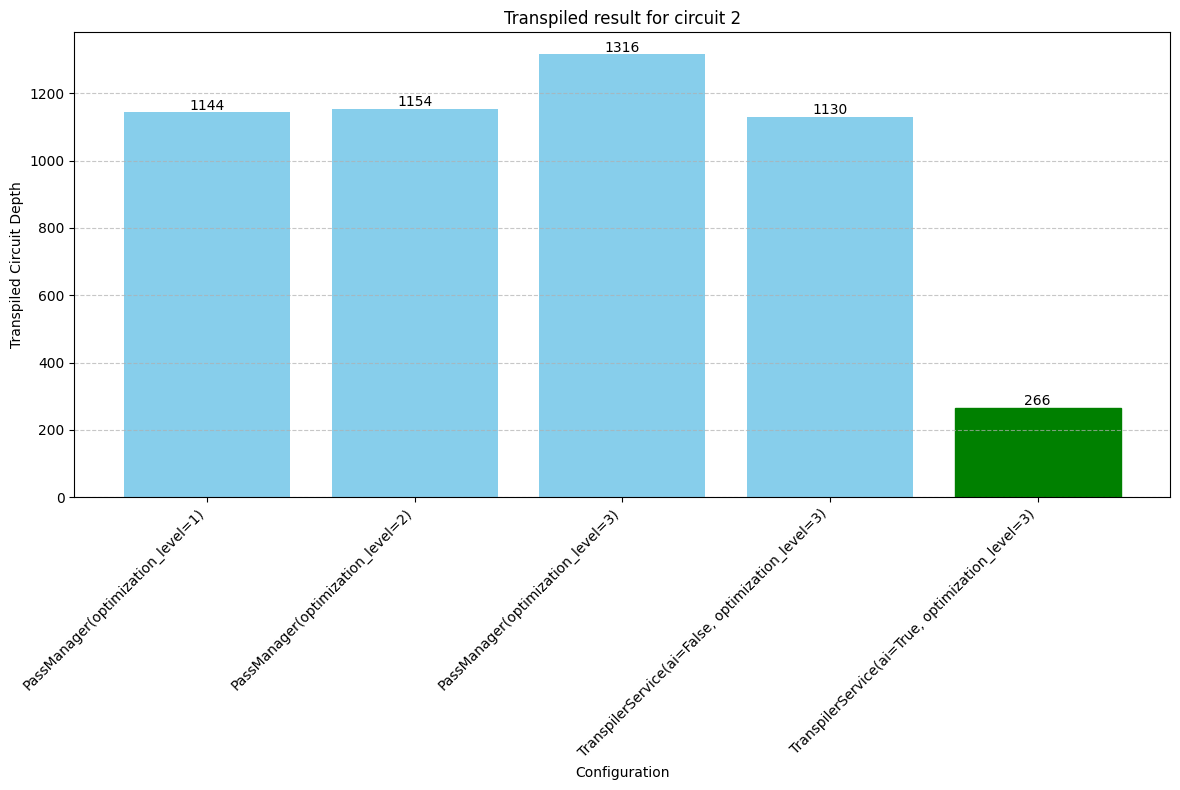

In [53]:
from utils import process_transpiled_circuits

best_circuits, best_depths, best_methods = process_transpiled_circuits(configs, result_transpiled)

In [54]:
# Display the best circuits, depths, and methods
for i, (circuit, depth, method) in enumerate(zip(best_circuits, best_depths, best_methods)):
    print(f"Best result for circuit {i + 1}:")
    print(f"  Depth: {depth}")
    print(f"  Method: {method}")
    # Display or process the best circuit as needed
    # e.g., circuit.draw(output="mpl")

Best result for circuit 1:
  Depth: 215
  Method: TranspilerService(ai=True, optimization_level=3)
Best result for circuit 2:
  Depth: 232
  Method: TranspilerService(ai=True, optimization_level=3)
Best result for circuit 3:
  Depth: 266
  Method: TranspilerService(ai=True, optimization_level=3)


<div class="alert alert-block alert-warning">
<b>Bonus Exercise: Custom Optimizer with Parallelized Search Space Exploration for VQE: </b> 
    
<br>Now that you've completed the main section, let's expand your knowledge with a bonus exercise! Can you think of a way to implement your own optimizer to parallelize the search space exploration for the Variational Quantum Eigensolver (VQE) or other iterative quantum algorithms? Try to create optimization strategies that can execute multiple parameter sets in parallel and leverage Qiskit Serverless for distributed computation for an added speed and efficiency boost for the search process.

Feel free to share your attempts and approaches on Discord for a lively discussion with the community!
</div>

Congratulations on completing the Qiskit Serverless section! You've successfully explored the powerful capabilities of Qiskit Serverless, learning how to deploy and execute quantum algorithms without worrying about infrastructure management. By leveraging this serverless architecture, you can focus more on your code and efficiently utilize both quantum and classical resources. This experience has provided you with valuable insights into running quantum workflows in a seamless, scalable manner on cloud. Additionally, you've gained an understanding of how to implement parallel workflows on Qiskit Serverless to maximize efficiency and performance. Keep experimenting with Qiskit Serverless to further explore more possiblities. Great job!

# Additional information

**Created by:** Vishal Sharathchandra Bajpe

**Advised by:** Tushar Mittal, Sanket Panda, Junye Huang, Jessie Yu, Jennifer Glick

**Version:** 1.1.2